# Creating seismic synthetics with Devito and GemPy
In this tutorial, we aim to provide a start-to-finish guide for creating synthetic seismic models and datasets using the open-source packages Devito and GemPy. We will highlight the steps involved, from creating a 3D geological model, to forward modelling, to visualisation.

## Goals
* Introduce users to creating simple geological models with GemPy
* Illustrate how to include physical properties in the geological model and how to convert this into a format usable for seismic modelling with Devito
* Set up a Devito `operator` to solve the 2nd order acoustic wave equation, including sparse sources and receivers
* Forward propagate a shot through the model, and record a synthetic gather using receivers
* Visualise the wavefield in 3D using slicing in PyVista

## Structure
This tutorial will be presented in two halves, with a break at approximately 09:00 UTC (10:00 BST). The first half will focus on creating the seismic synthetic, whilst the latter will cover the seismic wave modelling itself.

Throughout the tutorial, several members of the team will be available in the `#t21-thurs-devito` channel of the [Software Underground Slack](https://softwareunderground.org/slack). For in-depth GemPy questions, the `#gempy` channel is another option. For Devito-centric questions, try the `#devito` channel or the [Devito Slack](https://devitocodes.slack.com/).

## Motivation
Synthetic seismic models are crucial for testing and benchmarking numerous seismic modelling and imaging applications. Whilst several seismic synthetics  are commonplace within the community for example the ubiquitous Marmousi model, or the SEG/EAGE Salt and Overthrust Models, the range of freely-available synthetics is relatively small, with other purpose-built models carrying a steep cost. Furthermore currently-available seismic synthetics may not bear sufficient resemblence to the desired target, or may be lacking certain material properties required for a particular wave equation. This has implications for both accessibility and reproducibility of studies, as benchmarks used may not be readily available for others to verify the work.

By using freely-available tools to create synthetic models and datasets, we can create open, sharable, customisable models for a wide range of applications.

## GemPy installation
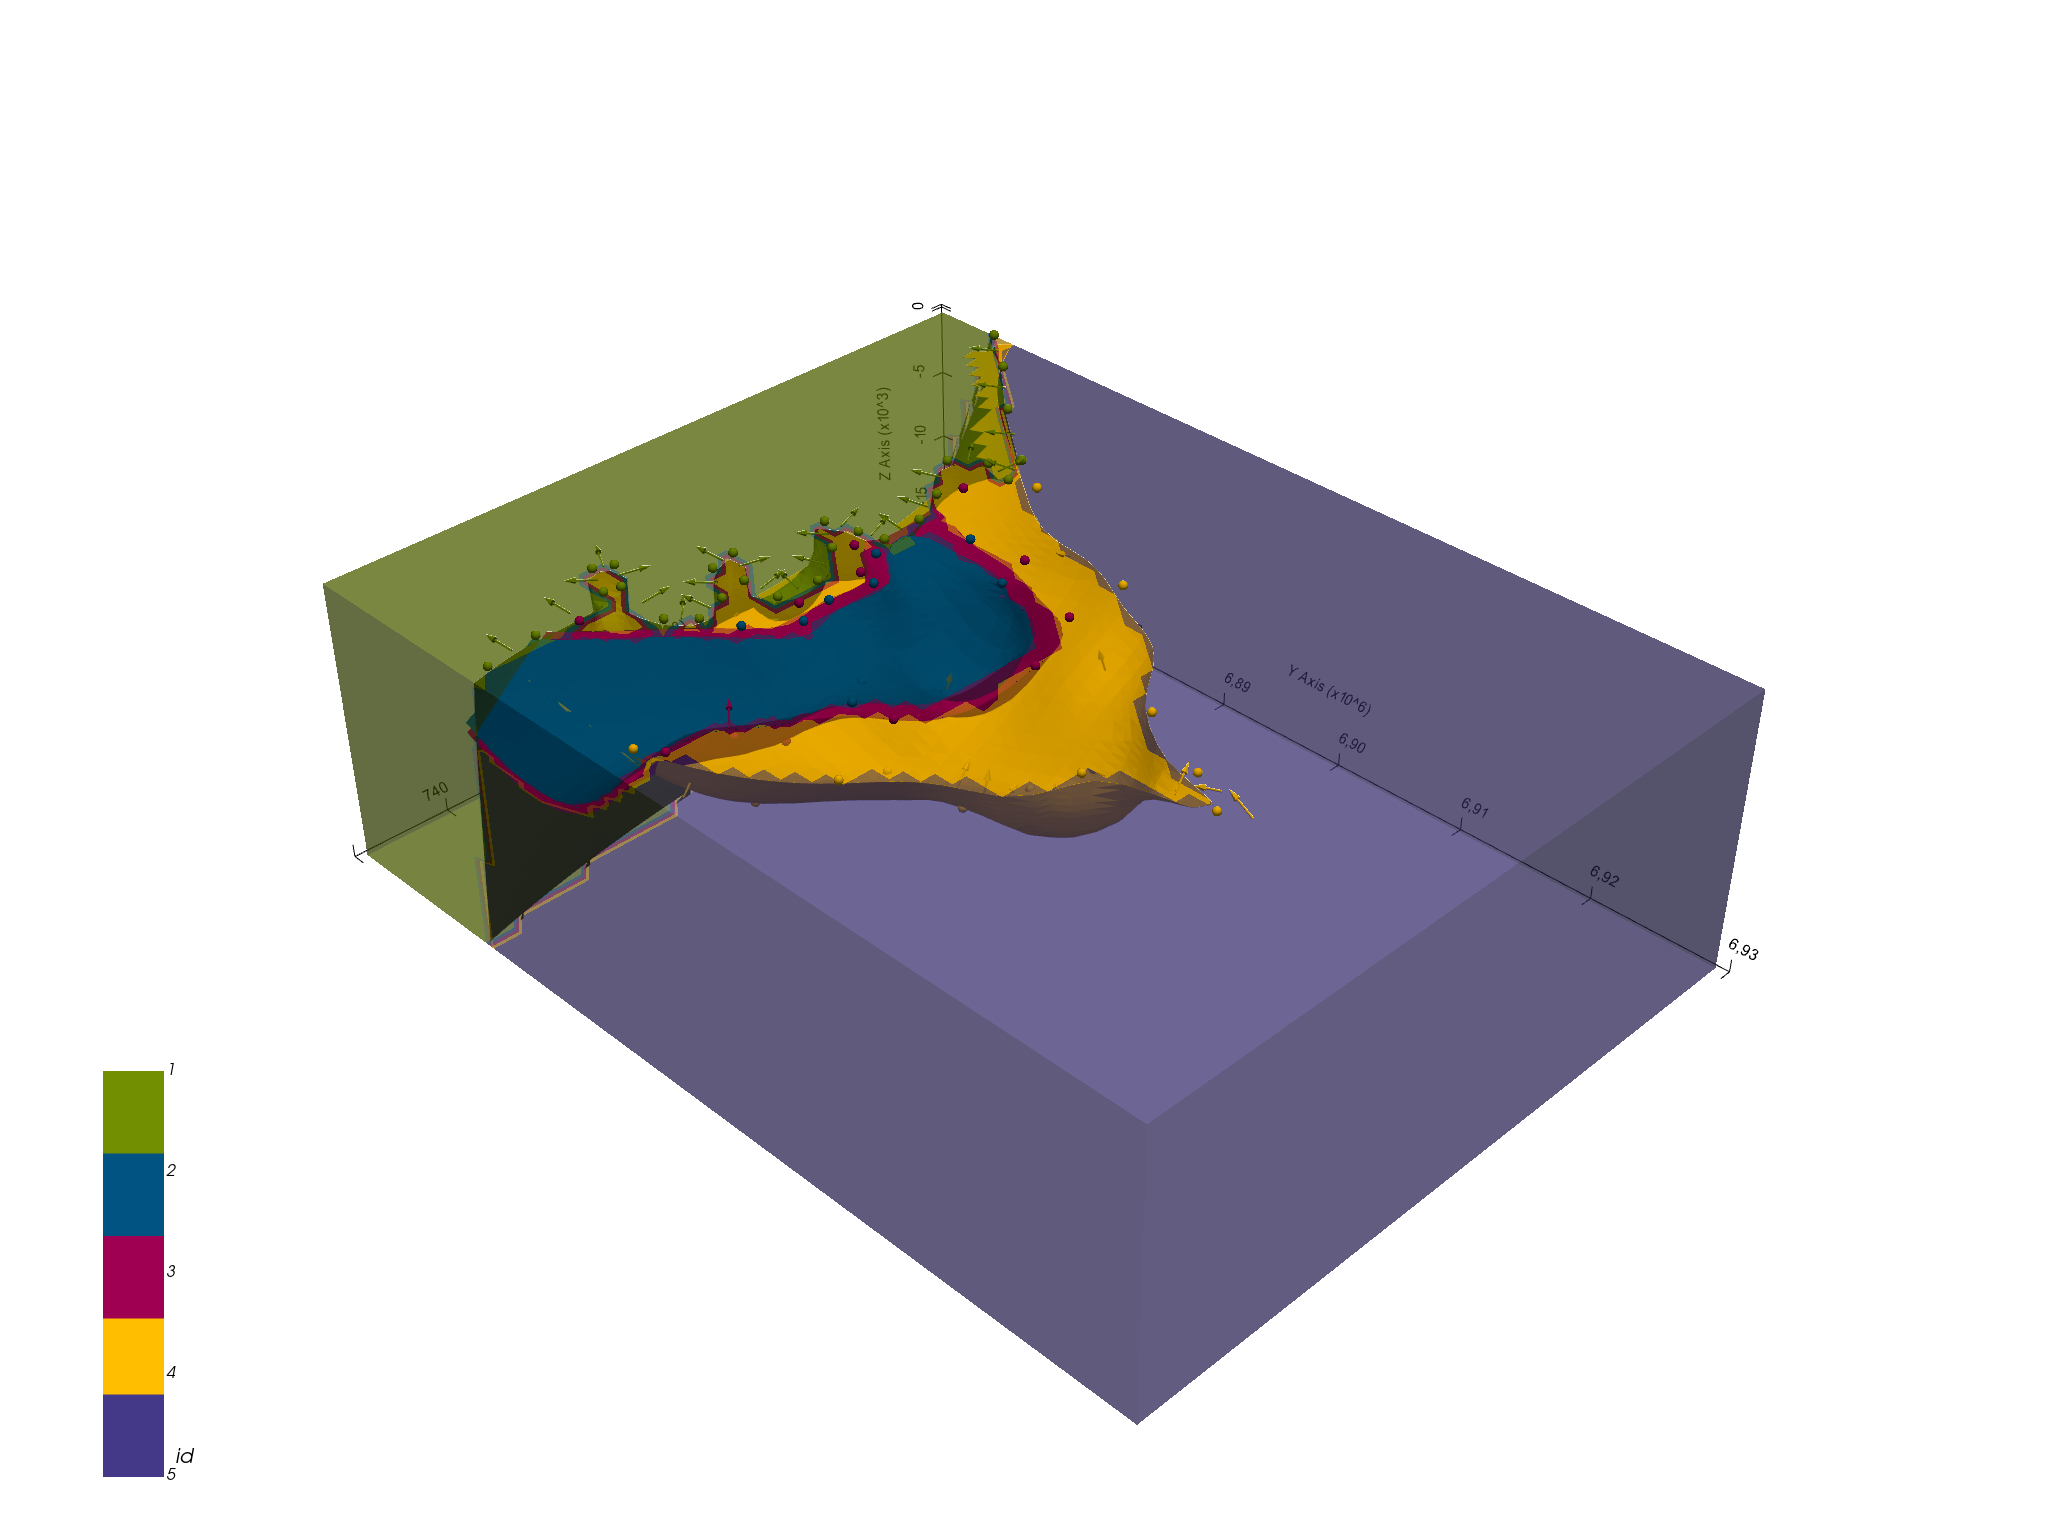

The synthetics which we will be building in this tutorial will be made with the use of GemPy, an open-source 3D geological modelling package for Python. If not already installed, we will need to install it. If issues are encountered whilst installing GemPy into a `conda` environment using `pip`, you can alternatively create a python `venv` and install into this environment using `pip` as per usual. Note that it will also be necesary to install an `ipykernel` in this environment to run this notebook. From here, we can install GemPy:

In [1]:
try:
    # Import gempy
    import gempy as gp
except ModuleNotFoundError:
    # Install gempy
    ! pip install gempy
    # Import gempy
    import gempy as gp

# Check jinja2 is installed for colour-coding of geological units
try:
    import jinja2
except ModuleNotFoundError:
    ! pip install jinja2
    import jinja2

No module named 'osgeo'


## Model overview

The simple geological model which we will be building is designed to evoke carbon-capture and storage (CCS) scenarios.

The model consists of a CO2 lens in a sandstone reservoir, with a shale layer in the overarching anticline providing the structural trap. This is then overlain by a layer of sediment, with water at the top of the model. Geological strata and their respective velocities are based on values detailed in https://doi.org/10.1190/geo2012-0216.1 with a similar shale trap/permeable sandstone reservoir structure (albeit with a small number of thick layers rather than the thin interbedding, to limit model complexity for this tutorial). Further inspiration was taken from https://doi.org/10.1016/j.energy.2004.03.071 .


## Creating our geological model:

To begin, alongside GemPy, we need to import some  auxiliary modules:

In [2]:
# Import auxiliary modules
import numpy as np

%matplotlib inline

### Initial setup

We will now set up a GemPy `Model` object. This encapsulates the grid onto which the scalar fields associated with various surfaces are interpolated. Note that the extent is slightly greater than it will be for our Devito model (an extra half a grid spacing is added to each side). This is due to differences in the way in which grids are defined in each package and is necessary to ensure that the model is not stretched and distorted when transistioning between the two.

In [3]:
# Set overarching model parameters
extent = (-5., 1005., -5., 1005., -1005., 5.)
shape = (101, 101, 101)

geo_model = gp.create_model('transform-2021')
geo_model = gp.init_data(geo_model, extent=extent, resolution=shape)

Active grids: ['regular']


We now need to set up Theano for our model (used by GemPy for interpolation of model properties). Bear in mind that that this may take some time to run.

In [4]:
gp.set_interpolator(geo_model, output=['geology'], theano_optimizer='fast_compile')

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                        values
range             1749.371316
$C_o$            72864.285714
drift equations           [3]


### Adding geological units
As the top CO2 surface is truncated by the upper shale layer, we will need to separate the geological strata into two GemPy `Series`. Each `Series` object, as the name suggests is intended to correspond with a geological unit, and they can be made to onlap, erode, etc one another. Whilst in practice, the top CO2 contact is not an erosive surface, treating it as such is the most straightforward way to create the desired truncation, as the shale trap is unconformable on the CO2 lens and reservoir sandstone.

A default series is included in the model. As such, rather than creating a new series, we will simply rename it to 'Lower'. As you can imagine, this is going to be used to contain the lower geological units, these being the lower shale, reservoir sandstone, and CO2 lens.

In [5]:
geo_model.rename_series({'Default series': 'Lower'})

And now add our surfaces:

In [6]:
geo_model.add_surfaces(['co2', 'sands', 'lowershale'])

,surface,series,order_surfaces,color,id
0,co2,Lower,1,#015482,1
1,sands,Lower,2,#9f0052,2
2,lowershale,Lower,3,#ffbe00,3


We will now set some points for the base of the sands and CO2. The lower shale is considered the basement, meaning that its base does not need to be defined and it will extend to the bottom of the model. Alongside these points, we wil need to define an orientation for the surface.

To minimise repetition, we will define a function to loop over a list of points and add each to the surface.

In [8]:
def create_surface(model, points, surface):
    """Add a list of points to a surface in a model"""
    xyz = ('X', 'Y', 'Z')
    for point in points:
        kwargs = {**dict(zip(xyz, point)), 'surface': surface}
        model.add_surface_points(**kwargs)

# The points defining the base of the sand layer
sand_points = [(322, 135, -783), (635, 702, -791), (221, 668, -772), (732, 235, -801), (442, 454, -702)]

# Call our function
create_surface(geo_model, sand_points, 'sands')

# Add the surface orientation
geo_model.add_orientations(X=442., Y=495., Z=-752.,
                           surface='sands', pole_vector=(0.05, 0.05, 0.95))

,X,Y,Z,G_x,G_y,G_z,smooth,surface
0,442.0,495.0,-752.0,0.05,0.05,0.95,0.01,sands


We will now repeat this process for the CO2 lens.

In [9]:
# Points defining the base of the CO2 layer
co2_points = [(322, 135, -650), (635, 702, -650), (221, 668, -650), (732, 235, -650), (442, 454, -650)]

create_surface(geo_model, co2_points, 'co2')

# Add the surface orientation
geo_model.add_orientations(X=495., Y=495., Z=-650.,
                           surface='co2', pole_vector=(0., 0., 1.))

,X,Y,Z,G_x,G_y,G_z,smooth,surface
1,495.0,495.0,-650.0,0.00,0.00,1.00,0.01,co2
0,442.0,495.0,-752.0,0.05,0.05,0.95,0.01,sands


We will now add an upper series, containing statigraphy above the CO2 lens.

In [10]:
geo_model.add_series('Upper')

,order_series,BottomRelation,isActive,isFault,isFinite
Lower,1,Erosion,True,False,False
Upper,2,Erosion,False,False,False


As we can see, the upper series has been added below the lower series. This is not ideal for obvious reasons, and hence we will reorder them:

In [11]:
geo_model.reorder_series(['Upper', 'Lower'])

,order_series,BottomRelation,isActive,isFault,isFinite
Upper,1,Erosion,False,False,False
Lower,2,Erosion,True,False,False


And add our remaining surfaces:

In [12]:
geo_model.add_surfaces(['water', 'sediments', 'uppershale'])

,surface,series,order_surfaces,color,id
0,co2,Lower,1,#015482,1
1,sands,Lower,2,#9f0052,2
2,lowershale,Lower,3,#ffbe00,3
3,water,Lower,4,#728f02,4
4,sediments,Lower,5,#443988,5
5,uppershale,Lower,6,#ff3f20,6


As these surfaces are not mapped to the upper series by default, we shall do so:

In [13]:
gp.map_stack_to_surfaces(geo_model, {'Upper': ('water', 'sediments', 'uppershale')})

,surface,series,order_surfaces,color,id
3,water,Upper,1,#728f02,1
4,sediments,Upper,2,#443988,2
5,uppershale,Upper,3,#ff3f20,3
0,co2,Lower,1,#015482,4
1,sands,Lower,2,#9f0052,5
2,lowershale,Lower,3,#ffbe00,6


Now we will add the points for the upper series. Note that there is only a single orientation included. It is not necessary to define an orientation for each surface, so long as there is an orientation in the series.

In [18]:
# Surface points
uppershale_points = [(322, 135, -633), (635, 702, -641), (221, 668, -622), (732, 235, -651), (442, 454, -552)]
sediments_points = [(322, 135, -433), (635, 702, -441), (221, 668, -422), (732, 235, -451), (442, 454, -352)]
water_points = [(232, 153, -221), (653, 234, -216), (112, 872, -198), (532, 572, -223),
                (722, 884, -189), (632, 429, -201), (732, 348, -222)]

# Add the points to our surfaces
create_surface(geo_model, uppershale_points, 'uppershale')
create_surface(geo_model, sediments_points, 'sediments')
create_surface(geo_model, water_points, 'water')

# Set an orientation
geo_model.add_orientations(X=442., Y=495., Z=-502.,
                           surface='uppershale', pole_vector=(0.05, 0.05, 0.95))

,X,Y,Z,G_x,G_y,G_z,smooth,surface
2,442.0,495.0,-502.0,0.05,0.05,0.95,0.01,uppershale
1,495.0,495.0,-650.0,0.00,0.00,1.00,0.01,co2
0,442.0,495.0,-752.0,0.05,0.05,0.95,0.01,sands


### Adding physical properties (Vp)

Finally, we can add the p-wave velocities associated with each of these layers. Note that any parameter can be set in this manner (density, elastic parameters, attenuation, etc) if desired for more complex synthetics. This is one of the benefits of using GemPy to create these synthetics: models can be expanded upon with a huge suite of material properties.

In [14]:
geo_model.add_surface_values([1.5, 1.75, 2.5, 1.1, 2., 2.5], ['vp'])
geo_model.surfaces

,surface,series,order_surfaces,color,id,vp
3,water,Upper,1,#728f02,1,1.500000
4,sediments,Upper,2,#443988,2,1.750000
5,uppershale,Upper,3,#ff3f20,3,2.500000
0,co2,Lower,1,#015482,4,1.100000
1,sands,Lower,2,#9f0052,5,2.000000
2,lowershale,Lower,3,#ffbe00,6,2.500000


### Visualising the GemPy model

Now we can visualise our model, plotting data points and orientations. Firstly, the model must be computed to interpolate the surfaces and any associated scalar fields. Then we can plot our surfaces and the associated units.

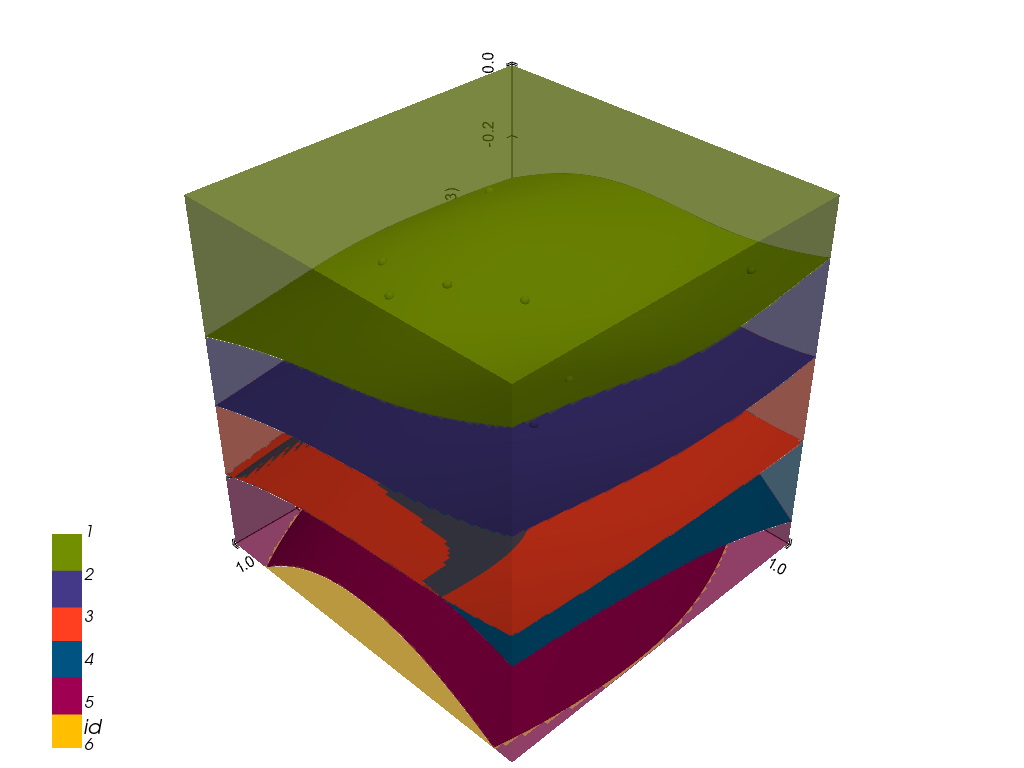

[StructuredGrid (0x7fe16430cbb0)
   N Cells:	1000000
   N Points:	1030301
   X Bounds:	0.000e+00, 1.000e+03
   Y Bounds:	0.000e+00, 1.000e+03
   Z Bounds:	-1.000e+03, 0.000e+00
   Dimensions:	101, 101, 101
   N Arrays:	1,

In [20]:
# Set up plotter
p3d = gp.plot_3d(geo_model, notebook=True)
# Plot data points and orientations
p3d.plot_data()

# Compute the model. Note that a solution is returned. We will use this later
sol = gp.compute_model(geo_model)

# Plot the surfaces
p3d.plot_surfaces()
# Plot the lithological units
p3d.plot_structured_grid('lith')

## Bridging the gap from GemPy to Devito:

As you may have noticed, when we compute our GemPy model, a `Solution` object is returned. From this, we can extract the rasterized values attached to each of our geological units. With this in mind, we can print the solution values:

In [21]:
sol.values_matrix

array([[2.5       , 2.44720385, 2.        , ..., 1.5       , 1.5       ,
        1.5       ]])

You will notice that these values correspond with the p-wave velocities we specified. However, they are in the form of 1D vector. Consequently, will need to reshape this array to fit into the `vp` parameter of a Devito `Model`. This can be done with further parameters such as density or shear wave velocity for more complex models. In this case, you would want to set up a Devito `Function` to contain each parameter.

Note that in this case, we need to select c-like index order to get the axes in the correct order.

In [23]:
# Reshaping our data to the shape required by Devito
reshaped = np.reshape(sol.values_matrix, shape, order='C')
reshaped.shape

(101, 101, 101)

### Quality checking

Now let us plot a slice through this model for quality checking purposes. Note that we need to bear Devito's `[x, y, z]` indexing convention in mind.

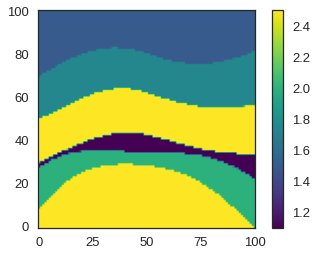

In [24]:
import matplotlib.pyplot as plt

# Take the center slice in the x direction
# Remember that in Devito, indexing convention is [x, y, z] (need to flip for correct imshow display)
plt.imshow(reshaped[50].T, cmap='viridis', origin='lower')
plt.colorbar()
plt.show()

The model looks good, and we can see the geometry of the CO2 lens clearly. We are now ready to begin our seismic modelling with Devito.

## Break Time!
Time to go and get a coffee.

## Seismic modelling with Devito

We can now start building our Devito model. The following draws heavily from the Devito `examples/sesimic/tutorials/01_modelling.ipynb` notebook. We will begin, as always with some imports. If Devito is not installed, we will need to install it.

In [ ]:
try:
    # Import devito
    import devito as dv
    from examples.seismic import Model
except ModuleNotFoundError:
    # Install devito
    ! pip install devito
    # Import devito
    import devito as dv
    from examples.seismic import Model

### Modelling workflow
The core process we are aiming to model is a seismic survey, which consists of two main components:
* **Source** - A source is positioned at a single or a few physical locations where artificial pressure is injected into the domain we want to model. In the case of land survey, it is usually dynamite, or a vibroseis (a truck fitted with a vibrating plate generating continuous sound waves). For a marine survey, the source is an air gun sending a bubble of compressed air into the water that will expand and generate a seismic wave.
* **Receivers** - A set of geophones or hydrophones are used to measure the resulting wave and create a set of measurements called a "Shot Record" or "Shot Gather". These measurements are recorded across an array, usually located near the surface, although they may be a depth in the case of ocean-bottom seismometers (OBS) or downhole receivers.

In order to create a numerical model of a seismic survey, we need to solve a wave equation and implement source and receiver interpolation to inject the source and record the seismic wave at sparse point locations in the grid.

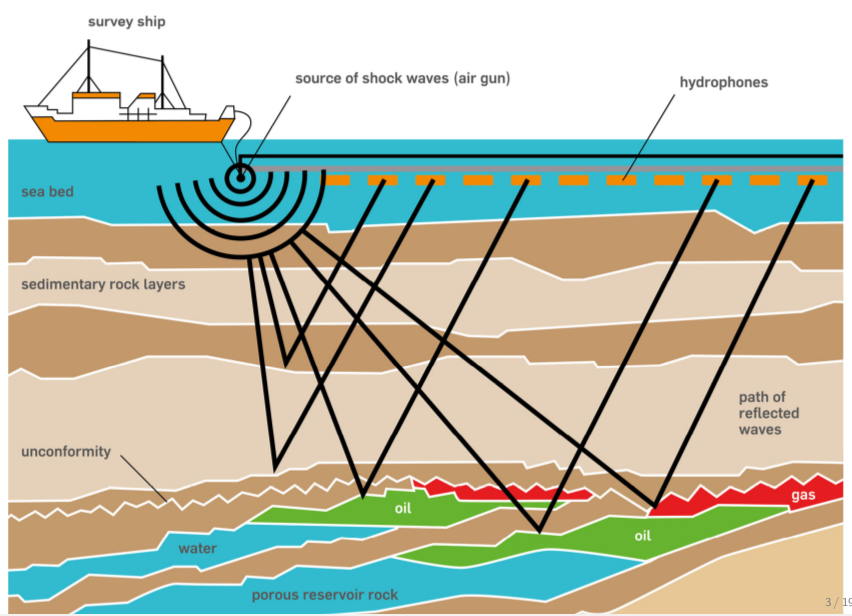

### The acoustic wave equation
The acoustic wave equation for the square slowness $m$, defined as $m=\frac{1}{c^2}$, where $c$ is the speed of sound in the given physical media, and a source $q$ is given by:

\begin{cases}
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) = q \ \text{in } \Omega \\
 &u(.,t=0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

with the zero initial conditions to guarantee unicity of the solution.
The boundary conditions are Dirichlet conditions:
\begin{equation}
 u(x,t)|_\delta\Omega = 0
\end{equation}

where $\delta\Omega$ is the surface of the boundary of the model $\Omega$.

### Finite domains

The last piece of the puzzle is the computational limitation. In the field, the seismic wave propagates in every direction to an "infinite" distance. However, solving the wave equation in a mathematically/discrete infinite domain is not feasible. In order to compensate, Absorbing Boundary Conditions (ABC) or Perfectly Matched Layers (PML) are required to mimic an infinite domain. These two methods allow to approximate an infinite media by damping and absorbing the waves at the limit of the domain to avoid reflections.

The simplest of these methods is the absorbing damping mask. The core idea is to extend the physical domain and to add a Sponge mask in this extension that will absorb the incident waves. The acoustic wave equation with this damping mask can be rewritten as:

\begin{cases} 
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) + \eta \frac{d u(x,t)}{dt}=q  \ \text{in } \Omega \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

where $\eta$ is the damping mask equal to $0$ inside the physical domain and increasing inside the sponge layer. Multiple choices of profile can be chosen for $\eta$ from linear to exponential.

### Defining the physical problem

The first step is to define the physical model:

* What are the physical dimensions of interest?
* What is the velocity profile of this physical domain?

We will use the velocity velocity model which we have just created using GemPy. As such we need to create a physical domain of the same size. As mentioned earlier, Devito and GemPy have slightly different grid implementations, which we will need to bear in mind to ensure our Devito model maps correctly to the GemPy grid.

We can now construct a Devito `Model`. This is a convenience object encapsulating the necessary parameters and components of an acoustic wave model, including additional damping layers around the perimeter (specified by `bcs="damp"`). For implementing custom damping setups, see `examples/userapi/04_boundary_conditions.ipynb` in the Devito repository. Note that we are using a relatively large number of damping layers here. This is to avoid our gathers becoming too messy, and ensure that reflections from horizons can be straightforwardly identified in the gathers. These damping layers are added to the edge of the specified model, increasing its extent (this is important for later visualisation).

In [ ]:
seis_model = Model(vp=reshaped, origin=(0., 0., -1000.), spacing=(10., 10., 10.), shape=shape, nbl=30, space_order=4, bcs="damp")

### Acquisition geometry
To fully define our problem setup we also need to define the source that injects the wave to model and the set of receiver locations at which to sample the wavefield. The source time signature will be modelled using a Ricker wavelet defined as

\begin{equation}
  q(t) = (1-2\pi^2 f_0^2 (t - \frac{1}{f_0})^2 )e^{- \pi^2 f_0^2 (t - \frac{1}{f_0})}
\end{equation}

To fully define the source signature we first need to define the time duration for our model and the timestep size, which is dictated by the CFL condition and our grid spacing. Luckily, our `Model` utility provides us with the critical timestep size, so we can fully discretize our model time axis as an array:

In [ ]:
from examples.seismic import TimeAxis

t0 = 0.  # Simulation starts at t=0
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = seis_model.critical_dt  # Time step from model grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

We will position our source at a depth of 20m, center it in all other axes, and set the peak wavelet frequency to 15Hz.

In [ ]:
from examples.seismic import RickerSource

f0 = 0.015  # Source peak frequency is 15Hz (0.015 kHz)
src = RickerSource(name='src', grid=seis_model.grid, f0=f0,
                   npoint=1, time_range=time_range)

# First, position source centrally in all dimensions, then set depth
src.coordinates.data[:] = np.array(seis_model.domain_size) * .5
src.coordinates.data[0, -1] = -20  # Depth is 20m

# We can plot the time signature to see the wavelet
src.show()

Similarly to our source object, we can now define our receiver geometry as a symbol of type `Receiver`. It is worth noting here that both utility classes, `RickerSource` and `Receiver` are thin wrappers around the Devito's `SparseTimeFunction` type, which encapsulates sparse point data and allows us to inject and interpolate values into and out of the computational grid. As we have already seen, both types provide a `.coordinates` property to define the position within the domain of all points encapsulated by that symbol. 

In this example we will position receivers at the same depth as the source, every $10m$ along the x axis, on the midline of the y axis. The `rec.data` property will be initialized, but left empty, as we will compute the receiver readings during the simulation.

In [ ]:
from examples.seismic import Receiver

# Create symbol for 101 receivers
rec = Receiver(name='rec', grid=seis_model.grid, npoint=101, time_range=time_range)

# Prescribe even spacing for receivers along the x-axis
rec.coordinates.data[:, 0] = np.linspace(0, seis_model.domain_size[0], num=101)
rec.coordinates.data[:, 1] = 0.5*seis_model.domain_size[1]
rec.coordinates.data[:, -1] = -20.  # Depth is 20m

### Wave equation and specification

As mentioned previously, we will be using the 2nd order acoustic wave equation in this tutorial. One of the key features of Devito is the ability to specify an equation, or system of equation, in a symbolic manner, and have this automatically discretized using the finite difference method.

In Devito, variables which vary in space only are represented using `Function` objects. If we also want them to vary over time, we must use a `TimeFunction`. There are further `Function`s for vector and tensor objects. The discretization is specified using the `time_order` and `space_order` keyword arguments. In this case we will use a discretization with 2nd order accuracy in time, and 4th order accuracy in space.

To take the first of a variable `u` with respect to a dimension `x`, you can simply write `u.dx`, or `u.dx2` for the second derivative. For other dimensions (including time), simply swap out the `x`.

In [ ]:
# Define the wavefield with the size of the model
u = dv.TimeFunction(name="u", grid=seis_model.grid, time_order=2, space_order=4)

# Show the derivative stencil
u.dx2

With this, we can define our partial differential equation, essentially as we would write it on paper:

In [ ]:
# We can now write the PDE
pde = seis_model.m * u.dt2 - u.laplace + seis_model.damp * u.dt

# The PDE representation is as on paper
pde

Now we can create our update stencil to get the solution at the forward timestep:

In [ ]:
# This discrete PDE can be solved in a time-marching way updating u(t+dt) from the previous time step
# Devito as a shortcut for u(t+dt) which is u.forward. We can then rewrite the PDE as 
# a time marching updating equation known as a stencil using customized SymPy functions

stencil = dv.Eq(u.forward, dv.solve(pde, u.forward))
stencil

### Source injection and receiver interpolation

With a numerical scheme to solve the homogenous wave equation, we need to add the source to introduce seismic waves and to implement the measurement operator, and interpolation operator. This operation is linked to the discrete scheme and needs to be done at the proper time step.

With this in mind, we can set up the source and reciever terms to include in our `Operator`.

In [ ]:
# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / seis_model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

### Devito operator and solve (where the magic happens)
After constructing all the necessary expressions for updating the wavefield, injecting the source term and interpolating onto the receiver points, we can now create the Devito operator that will generate the C code at runtime. When creating the operator, Devito's two optimization engines will log which performance optimizations have been performed:
* **DSE:** The Devito Symbolics Engine will attempt to reduce the number of operations required by the kernel.
* **DLE:** The Devito Loop Engine will perform various loop-level optimizations to improve runtime performance.

**Note**: The argument `subs=model.spacing_map` causes the operator to substitute values for our current grid spacing into the expressions before code generation. This reduces the number of floating point operations executed by the kernel by pre-evaluating certain coefficients.

In [ ]:
op = dv.Operator([stencil] + src_term + rec_term, subs=seis_model.spacing_map)

Now we can execute the operator for a number of timesteps. We specify the number of timesteps to compute with the keyword `time` and the timestep size with `dt`.

In [ ]:
op(time=time_range.num-1, dt=seis_model.critical_dt)

### Plotting the synthetic shot record
We can now plot our shot record using everyone's favourite colourmap. We can clearly see the reflected arrivals from the seabed, top shale, and top CO2 (look for the reverse polarity arrival). We can also distinguish the base of the CO2 lens and the interface between the reservoir sandstone and the underlying shale.

In [ ]:
plt.imshow(rec.data, cmap='viridis', aspect='auto', vmax=0.01, vmin=-0.01, extent=(0, 100, tn, t0))
plt.xlabel("Reciever number")
plt.ylabel("Time (ms)")
plt.colorbar()
plt.show()

## Visualisation with PyVista:

In the final section of this tutorial, we will cover visualisation of the wavefield using PyVista: a dependency of GemPy. We can use its plotting and manipulation capabilities to visualise various slices of our wavefield.

Firstly, we need to import PyVista

In [ ]:
import pyvista as pv

With this done, we will want to take the 'data' attribute of 'u', containing the values of the field. This is a numpy array, indexed `[t, x, y, z]`, corresponding to the dimensions of `u`. As we want to plot the current (final) timestep, we will select time index 1.

In [ ]:
# Trim down the data from u to remove damping field
trimmed_data = u.data[1, 30:-30, 30:-30, 30:-30]

Now we will create a `UniformGrid`. This creates a simple uniform grid from a 3D NumPy array of values.

In [ ]:
# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(trimmed_data.shape) + 1

# Edit the spatial reference
grid.origin = (0., 0., -1000.)  # The bottom left corner of the data set
grid.spacing = (10, 10, 10)  # These are the cell sizes along each axis

We can now fill the grid cells with our wavefield data:

In [ ]:
# Add the data values to the cell data
grid.cell_arrays["values"] = trimmed_data.flatten(order="F")  # Flatten the array!

And plot some orthogonal slices of this grid to visualise its internal structure:

In [ ]:
orth_slices = grid.slice_orthogonal(x=200, y=200, z=-500)

orth_slices.plot(cmap='seismic', clim=[-0.01, 0.01])

An alternative visualisation is to take a series of slices along an axis. By setting each slice to be slightly transparent, it is possible to show a fairly complete image of the 3D structure without the need for in interactive plot.

In [ ]:
y_slices = grid.slice_along_axis(n=5, axis="y")
p = pv.Plotter()
p.add_mesh(grid.outline(), color="k")
p.add_mesh(y_slices, cmap='seismic', clim=[-0.01, 0.01], opacity=0.8)
p.show()

## Thank you for listening!
I hope this tutorial has been helpful. I will leave you with some helpful resources, and once again, feel free to ask on Slack if you have any questions!
* [Devito website](https://www.devitoproject.org/)
* [GemPy website](https://www.gempy.org/)